In [1]:
from google.colab import files
uploaded = files.upload()

Saving valser_2022-12-01T00.tmp to valser_2022-12-01T00.tmp
Saving valser_2022-12-02T00.tmp to valser_2022-12-02T00.tmp


In [2]:
!pip install livelossplot

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Subset, Dataset
import torchvision.transforms as transforms

import random 
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

set_device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    set_device = 'cuda'
else:
    print("No GPU available!")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cuda installed! Running on GPU!


In [3]:
n_sensors = 1
sequence_length = 10
batch_size = 10

class TsCSVDataset(Dataset):
    '''Generate Pytorch timeseries dataset from csv file'''
    
    def __init__(self, path, sequence_length, lag=1, 
                 mean=None, std=None, 
                 train_size=0.7, train=True):
        
        dataset = pd.read_csv(path)
        
        if len(dataset.columns) > 1:
            dataset.iloc[:,-1] = dataset.iloc[:,-1].shift(-lag, axis=0)
            dataset = dataset.iloc[:-lag]
        
        ttsidx = int(train_size*len(dataset.index))
        
        if mean is None and std is None:
            self.mean = dataset[:ttsidx].mean()
            self.std = dataset[:ttsidx].std()
            
        dataset  = (dataset - self.mean)/self.std

        if train:
            dataset = dataset.iloc[:ttsidx]
        else:
            dataset = dataset.iloc[ttsidx:]
            
        self.sequence_length = sequence_length
            
        if len(dataset.columns) > 1:
            self.targets = torch.tensor(dataset.iloc[:,-1].values, dtype=torch.float32)
            self.data = torch.tensor(dataset.iloc[:,:-1].values, dtype=torch.float32)
        else:
            self.targets = torch.tensor(dataset.iloc[lag:].values, dtype=torch.float32)
            self.data = torch.tensor(dataset.iloc[:-lag].values, dtype=torch.float32)         

        
    def __len__(self):
        return len(self.targets)

    
    def __getitem__(self, idx): 
        
        if idx >= self.sequence_length - 1:
            idx_start = idx - self.sequence_length + 1
            batch = self.data[idx_start:(idx+1)]
        else:
            padding = self.data[0].repeat(self.sequence_length-idx-1, 1)
            batch = self.data[0:(idx+1)]
            batch = torch.cat((padding, batch), 0)

        return batch, self.targets[idx]

train_dataset = TsCSVDataset('valser_2022-12-01T00.tmp', sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=False)
test_dataset = TsCSVDataset('valser_2022-12-01T00.tmp', sequence_length, train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=1, shuffle=False)

In [4]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.i2h = nn.Linear(input_size, hidden_size * 4, bias=bias)       
        self.h2h = nn.Linear(hidden_size, hidden_size * 4, bias=bias)     

        self.reset_parameters()                                            

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)

        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, h, c):
        gates = self.i2h(input) + self.h2h(h)                              

        input_gate, forget_gate, candidate_update, output_gate = gates.chunk(4, 1) 

        i_t = torch.sigmoid(input_gate)                                    
        f_t = torch.sigmoid(forget_gate)
        c_t = torch.tanh(candidate_update)
        o_t = torch.sigmoid(output_gate)

        c = f_t * c + i_t * c_t                                            

        h = o_t * torch.tanh(c)                                        

        return h,c

In [5]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=False):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()                        

        for l in range(self.num_layers):
            self.rnn_cell_list.append(LSTMCell(self.input_size if l == 0 else self.hidden_size,
                                               self.hidden_size,
                                               self.bias))

        self.h2o = nn.Linear(self.hidden_size, self.output_size)    

    def init_hidden(self,  batch_size=1, device=set_device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False).to(device))

    def forward(self, input, h0, c0):
        outs = []
        hidden = []
        cell = []

        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])
            cell.append(c0[layer, :, :])

        for t in range(input.size(1)):
            for layer in range(self.num_layers):

                if layer == 0:
                    hidden_l, cell_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer], cell[layer])
                else:
                    hidden_l, cell_l = self.rnn_cell_list[layer](hidden[layer-1], hidden[layer], cell[layer])

                hidden[layer] = hidden_l
                cell[layer] = cell_l

            outs.append(hidden_l)

        out = torch.stack([self.h2o(out) for out in outs], dim=1)

        return out      

In [6]:
class LSTM_GEN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_sensors):
        super(LSTM_GEN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_sensors = num_sensors
        self.batch_size = batch_size
        
        self.lstm = LSTM(self.input_size, self.hidden_size, self.num_layers, self.num_sensors) 

    def forward(self, x):
        state_h, state_c = self.lstm.init_hidden(x.size(0))   
        output = self.lstm(x, state_h, state_c)   

        return output


def count_trainable_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

In [7]:
def train_lstm_gen(model, optimizer, criterion, dataloader, device=set_device):
    model.train()                      
    train_loss, train_accuracy = 0, 0   
    
    for i, (x, y) in enumerate(dataloader):  
        x, y = x.to(device), y.to(device)   
        optimizer.zero_grad()   

        y_pred = model(x)                    
        loss = criterion(y_pred.permute(1,2,0), y)  
        train_loss += loss
        loss.backward()                     
        nn.utils.clip_grad_norm_(model.parameters(),10)
        optimizer.step()                     

    return train_loss/len(dataloader)


def valid_lstm_gen(model, criterion, dataloader, device=set_device):
    model.eval()                       
    valid_loss, valid_accuracy = 0, 0  
    
    for i, (x, y) in enumerate(dataloader):  
        x, y = x.to(device), y.to(device)   
        optimizer.zero_grad()                
        y_pred = model(x)                    
        
        loss = criterion(y_pred.permute(1,2,0), y)  
        valid_loss += loss

    return valid_loss/len(dataloader)

    

def predict_lstm_gen(model, data, next_values=10, device=set_device):
    model.eval()  

    for i in range(next_values):  
        x = torch.tensor([value for value in data[i:]]).reshape(1,sequence_length,1).to(device)  
        y_pred = model(x)                                                                 

        last_value_logits = y_pred[0][-1]                                                                      

        data.append(last_value_logits.detach().cpu().item())                                     

    return data

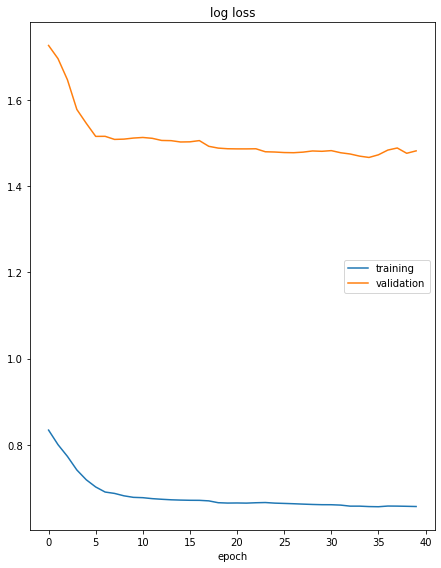

log loss
	training         	 (min:    0.656, max:    0.834, cur:    0.657)
	validation       	 (min:    1.467, max:    1.727, cur:    1.482)


In [8]:
input_size = n_sensors
n_hidden = 16                    
n_layers = 1
lr = 1e-2
momentum = 0.5
n_epochs = 40


lstm_gen = LSTM_GEN(input_size, n_hidden, n_layers, n_sensors).to(set_device)
print(f'The model has {count_trainable_parameters(lstm_gen):,} trainable parameters')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_gen.parameters(), lr=lr)

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_lstm_gen(lstm_gen, optimizer, criterion, train_loader)
    valid_loss = valid_lstm_gen(lstm_gen, criterion, test_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()

    liveloss.update(logs)
    liveloss.draw()

In [14]:
real = (pd.read_csv('valser_2022-12-02T00.tmp').iloc[:20] - train_dataset.mean.values)/train_dataset.std.values

pred = predict_lstm_gen(lstm_gen, real.iloc[:10].stack().tolist())

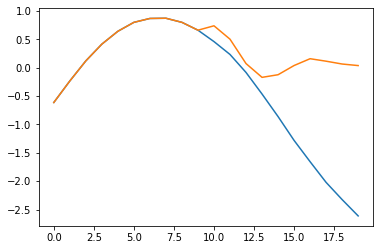

In [15]:
plt.plot([i for i in range(20)], real, [i for i in range(20)], pred)
plt.show()
